In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import gensim

import re
import warnings
import time
pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
reddit_df = pd.read_csv('/kaggle/input/23k-reddit-gaming-comments-with-sentiments-dataset/23k_r_gaming_comments_sentiments.csv')

In [4]:
import string
from nltk.corpus import stopwords

def clean_text(text):
    
    stop_words = stopwords.words("english")
    
    text = text.lower()
    
    text = re.sub(r"(@\S+|https*\S+|#\S+|\d+)", " ", text)
    
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    text = re.sub(r"\s+", " ", text)
    
    text = text.strip()
    
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [5]:
reddit_df['clean_com'] = reddit_df['Comment'].apply(clean_text)

In [6]:
reddit_df.clean_com = reddit_df.clean_com.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [7]:
tokenized_comm = reddit_df.clean_com.apply(lambda x: x.split())

In [8]:
import nltk
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
tokenized_comm = tokenized_comm.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [9]:
for i in range(len(tokenized_comm)):
    tokenized_comm[i] = ' '.join(tokenized_comm[i])    
reddit_df['clean_com'] = tokenized_comm

In [10]:
import plotly.express as px
fig = px.pie(reddit_df, names='sentiment', title ='Pie chart of different sentiments of reddit comments')
fig.show()

In [11]:
X = tokenized_comm.drop(columns=['sentiment'])

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

max_words = 10000
max_len=120

def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

X, tokenizer = tokenize_pad_sequences(X)

In [13]:
y = pd.get_dummies(reddit_df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [14]:
# tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=3, max_features=2000, stop_words='english', ngram_range=(1, 3))#, 
# X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
# X_val = tfidf_vectorizer.fit_transform(X_val).toarray()
# X_test = tfidf_vectorizer.transform(X_test).toarray()

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 10000
embedding_size = 32
epochs=23
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [16]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 120, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [17]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))


Accuracy  : 0.7393
Precision : 0.7734
Recall    : 0.6953


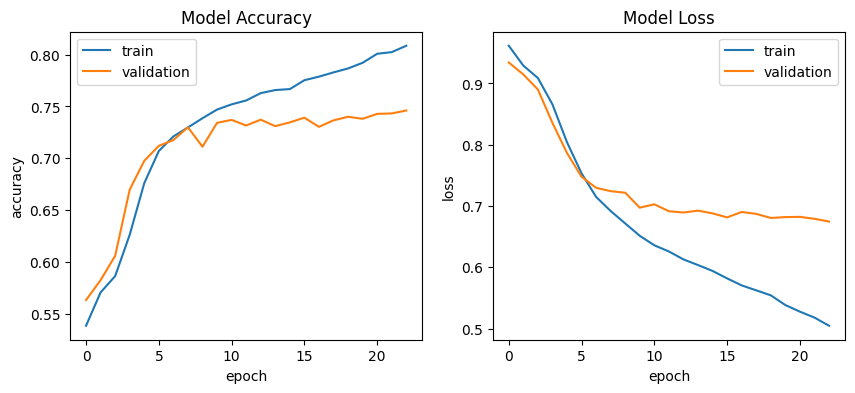

In [18]:
import matplotlib.pyplot as plt
def plot_training_hist(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

145/145 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.53      0.34      0.42       861
           1       0.73      0.83      0.78      1782
           2       0.81      0.83      0.82      1995

    accuracy                           0.74      4638
   macro avg       0.69      0.67      0.67      4638
weighted avg       0.73      0.74      0.73      4638



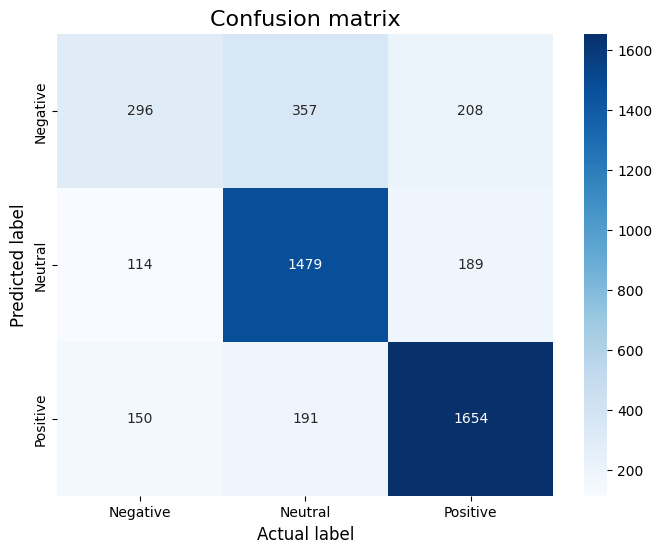

In [22]:
import numpy as np
import seaborn as sns
def plot_confusion_matrix(model, X_test, y_test):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']

    y_pred = model.predict(X_test)
    y_pred=np.argmax(y_pred, axis=1)
    y_test=np.argmax(y_test, axis=1)
    
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)